## Time Frequency Analysis

Towards the end of the previous chapter, we saw that doing frequency analysis on short time frames or segments within a long audio recording can reveal how the signal strength in various frequency components can change over time. We'll formalize this concept a bit more and introduce the short-time Fourier transform (STFT) and the spectrogram.

In [1]:
%pip install ipympl
import numpy as np 
from scipy import signal
from matplotlib import pyplot as plt
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
import io
from scipy.io import wavfile
from pyodide.http import pyfetch
%matplotlib ipympl

# function for reading WAV files from a URL. Must be a RAW link, not GitHub HTML
vocal = "https://raw.githubusercontent.com/randyaliased/acspjbook/main/book/audio/vocal_sample.wav"
birdcall = "https://raw.githubusercontent.com/randyaliased/acspjbook/main/book/audio/birdcall.wav"


async def read_wav_from_url(url):
    response = await pyfetch(url)
    wav_bytes = await response.bytes()  # get raw binary
    fs, data = wavfile.read(io.BytesIO(wav_bytes))

    # convert to float in [-1, 1]
    if np.issubdtype(data.dtype, np.integer):
        max_val = np.iinfo(data.dtype).max
        data = data.astype(np.float32) / max_val
    else:
        data = data.astype(np.float32)  # already float
    
    return data, fs

### Time-frequency representation

Time-frequency representations of signals allow us to quantify the nature of signals in terms of its spectral (frequency) variations over time. As illustrated in Fig. 1, time-frequency analysis involves the conversion of our signal in terms of time and amplitude to a "grid-like" representation where one axis represents time frames (some time segment of the signal) and the other frequency (recall that the frequency bins are simply the discrete indices corresponding to each of the frequencies, $k = 0, 1, 2, \dots N-1$). At each of these time-frequency points, we can define some quantity which tells us something about the strength of the signal at those times and frequencies, e.g., a power spectral density. 
<br>

<div>
<center> <img src="time_freq.png" width="550"/> <center/>
    <p style="text-align:center">Fig. 1 - Transforming from the time-domain to a time-frequency domain </p>
</div>

<br>
In this chapter, the time-frequency domain that will be used is the short-time Fourier transform (STFT), where the frequency scale is linear, meaning that there is a constant difference between adjacent frequency bins (i.e. each of the grid points in Fig. 1 is uniformly spaced in frequency). Other time-frequency transforms may however use non-linear frequency scales such as the [Mel scale](https://en.wikipedia.org/wiki/Mel_scale) or the equivalent [rectangular bandwidth (ERB)](https://en.wikipedia.org/wiki/Equivalent_rectangular_bandwidth). 

### Short time Fourier Transform (STFT)

Fig. 2 depicts the processing steps to obtain the STFT representation starting from the discrete-time domain signal, $x[n]$ in the upper-most plot. In the second step, $x[n]$ is segmented into fixed-length overlapping frames each consisting of $N$ samples. These time frames are then multiplied by another function, which we refer to as a **window** (specifically an analysis window since we are going from time to frequency, when going from frequency to time, we would distinguish this by the term synthesis window). The window, denoted as $w[n]$, is defined by some mathematical function for $n = 0, 1, 2, \dots N-1$ and set to zero outside this domain. We have in fact been using windows since the previous chapter when extracting time frames from a longer singal. In that case, the window was simply $w[n] = 1$ (for $n = 0, 1, 2, \dots N-1$), and is known as a rectangular window. However, there are [many different types of windows](https://en.wikipedia.org/wiki/Window_function) to choose from, each with its own set of tradeoffs, but this is not something I want to spend too much time on in this chapter (it perhaps deserves its own notebook for exploration in the future). Typically you will find that the [Hanning window](https://en.wikipedia.org/wiki/Hann_function) is preferred in many audio applications (also depicted in the 2nd row of Fig. 2 in red). This is because in comparison to a rectangular window, its edges smoothly taper off, and this results in desirable spectral properties. For a more comprehensive view on windows, [this is a great resource](https://ccrma.stanford.edu/~jos/sasp/Spectrum_Analysis_Windows.html).

Moving to the third row of Fig. 2, the $l^{th}$ windowed time frame can be mathematically defined as

\begin{equation}
     \bar{x} [n, l] = x[n + lR]  w[n]
\end{equation}
for $n =  [0, 1, . . . , N − 1]$,  $l = [0, 1, . . . , L − 1]$, where L is the total number of time frames, and R is the hop-size in samples. R directly defines the amount of overlap between frames, so for instance, if R = 256 and P = 512, then the amount of overlap is defined as 50%.

The final step of the STFT then involves taking a discrete Fourier transform (DFT) on each of these windowed time frames,  $\bar{x} [n, l]$, which yields complex-valued STFT coefficients:
\begin{equation}
X(k,l) = \sum_{n=0}^{N-1} \bar{x} [n, l] e^{-j 2\pi \frac{n k}{N}}
\end{equation}

where $k =  [0, 1, . . . , N − 1]$ is the frequency bin corresponding to the specific frequency (Hz), $f = \frac{k f_s}{N}$, where $f_s$ is the sampling frequency (Hz). With this, we now have the complex values $X(k,l)$ that can be assembled as per the matrix/tile type representation as shown on the right-hand-side illustration of Fig. 1.

<br>

<div>
<center> <img src="stft_process.png" width="550"/> <center/>
    <p style="text-align:center">Fig. 2 - Short time Fourier Transform (STFT) process </p>
</div>

<br>

Let's begin by importing our audio signal. We'll use the same vocal sample as before, but there's also a recording of a [Barred Antshrike](https://en.wikipedia.org/wiki/Barred_antshrike) that you can observe (simply change the variable 'vocal' to 'birdcall' in the code below).

/var/folders/ng/90xk1wjn2014rw8nb9bql2200000gp/T/ipykernel_37446/2697028720.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, xx = wavfile.read('../audio/vocal_sample.wav') # use locally


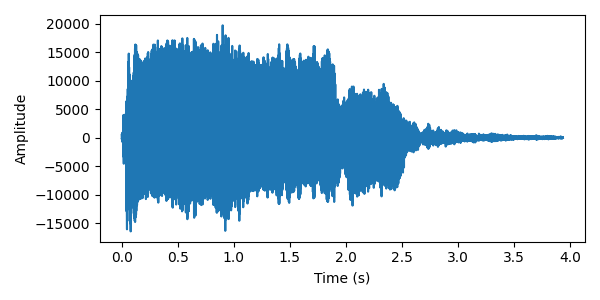

In [ ]:
# Import  signal
xx, fs = await read_wav_from_url(vocal)   # if you want to observe the bird call, change 'vocal' to 'birdcall' - we imported these URLs above.
t = np.arange(0,len(xx),1)*(1/fs) # time vector

IPython.display.display(Audio(xx.T, rate=fs))

fig, axes = plt.subplots(figsize=(6, 3)) 
axes.plot(t, xx)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()

### Spectrograms and Time/Frequency Resolution

Okay, now that we have imported our time domain signal and we know the sampling frequency of the signal, the next step is to compute the STFT of the signal. Up until this point, you have all the tools required to code this up yourself, but for the purposes to illustrating time-frequency tradeoffs, let's use some built-in python functions to do that for us . We will use the [scipy.signal.spectrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html) function. Upon computing the STFT of the signal, the result can be plotted in what we call a **Spectrogram**, where the magnitude, magnitude-squared, or power spectral density of the DFT coefficients are displayed as a colourmap over time and frequency. We will also use the [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) function in Python, typically used for plotting images, to plot the spectrogram. 

One of the parameters we need to choose before computing the STFT however, is the length of the time frames, $N$ (i.e. the number of samples over which we compute the DFT, see Fig. 2). Recalling our previous formula for the frequency, $f = kf_{s}/N$, for $k =  [0, 1, . . . , N − 1]$, we can define the frequency resolution, i.e. the spacing between each freuqency bin as:

\begin{equation}
\Delta f = \frac{f}{k} = \frac{f_{s}}{N}
\end{equation}

This equation tells us that we can essentially increase our frequency resolution by reducing the sampling frequency, $f_s$ or by increasing the number of of samples in each time frame, $N$. However, by increasing $N$, this will reduce the temporal resolution as each time frame will now be separated by more time, and hence fast, transient events may become difficult to visualize. This is the inherent time-frequency resolution trade-off that is encountered with the STFT, i.e. as frequency resolution increases, temporal resolution decreases and vice versa.

Let's have a look at the interactive plot below to see the impact of this, and we will also control the level of overlap to see how this will impact the spectrogram. For the vocal signal, you will now clearly see the rich spectral content varying over time and you can adjust $N$ accordingly to balance the trade-off between time and frequency. 


Move the slider to see the spectrogram for different values of nfft and noverlap:


interactive(children=(IntSlider(value=1024, description='N', max=2048, min=32, step=8), FloatSlider(value=0.5,…

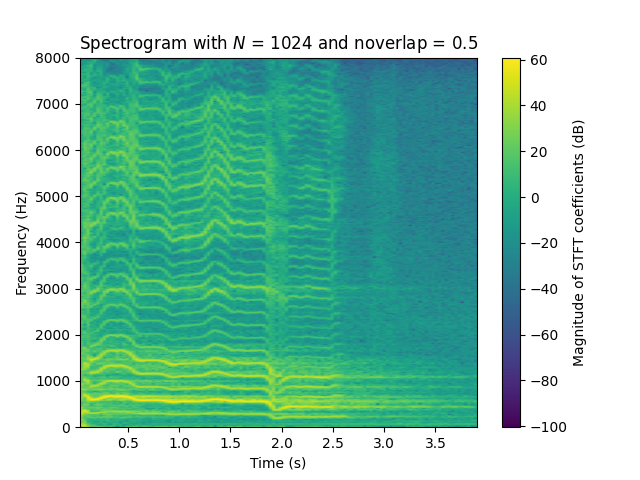

In [38]:
fig, axes = plt.subplots() 

# Computing the spectrogram. We use the package signal which has a spectrogram function
N = 1024            # number of points for the FFT 
noverlap = 0.5      # Spectrogram overlap (make it 50 % initially)

# Compute the spectrogram. We set the mode to obtain the magnitude, 
# i.e absolute magnitude of the short-time Fourier transform (STFT) coefficients.
# A window is usually applied to the smaller time chunks to reduce any high frequency artifcats. 
# The segments are also usually overlapped to smooth out the temporal variations

f_sg, t_sg, Z_mag = signal.spectrogram(xx, fs=fs,nperseg=N,window='hann',mode='magnitude',noverlap=noverlap*N)
Z_dB = 10*np.log10(Z_mag**2) # convert the magnitude to dB

# This is just some extra parameters for the imshow function, which allows you to plot a spectrogram
# The extent parameter is defining the corners of the image
extent = t_sg[0], t_sg[-1], f_sg[0], f_sg[-1]  # this defines the 4 corners of the "image"
sp = axes.imshow(Z_dB, origin='lower',aspect='auto',extent=extent)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Frequency (Hz)')

cb = plt.colorbar(sp,ax=[axes],location='right')
cb.set_label('Magnitude of STFT coefficients (dB)')

# The interactive plot:
def update(N = 1024, noverlap = 0.5):

    f_sg, t_sg, Z_mag = signal.spectrogram(xx, fs=fs,nperseg=N,window='hann',mode='magnitude',noverlap=noverlap*N)
    Z_dB = 10*np.log10(Z_mag**2) 
    fig.canvas.draw_idle()
    axes.set_title('Spectrogram with $N$ = '+ str(N)+ ' and noverlap = '+ str(np.round(noverlap,decimals=1)))
    sp.set_data(Z_dB)

print('Move the slider to see the spectrogram for different values of nfft and noverlap:')
interact(update, N = (2**5,2**11,2**3), noverlap =(0.1, 0.9,0.1));

IPython.display.display(Audio(xx.T, rate=fs))

### Power Spectral Density and window scaling

1. Derive scaling for windows
2. Implement our own spectrogram function to compute the PSD with this scaling.

/var/folders/ng/90xk1wjn2014rw8nb9bql2200000gp/T/ipykernel_37446/892368136.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, xx = wavfile.read('../audio/vocal_sample.wav') # use locally


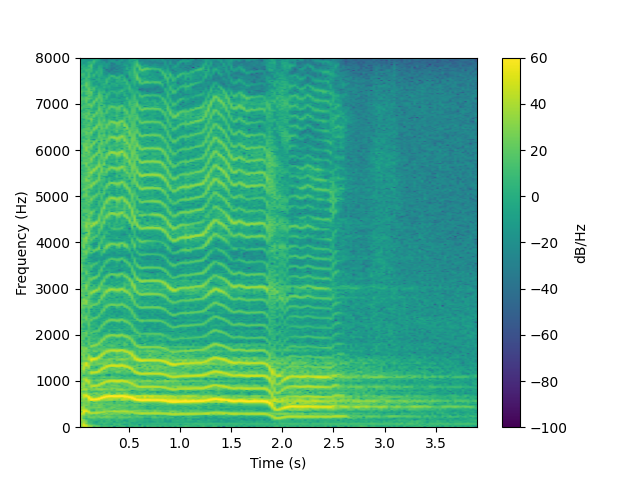

In [40]:
fs, xx = wavfile.read('../audio/vocal_sample.wav') # use locally

# Computing the spectrogram. We use the package signal which has a spectrogram function
N = 800            # number of points for the FFT 
noverlap = 0.5      # Spectrogram overlap (make it 50 % initially)

# Frame parameters - Change the frame_size to change the value of P 

frame_size=0.3 		     # Frame size in seconds
hop_size=frame_size/2    # This is an overlap of frames. This value is such that the next frame starts at the midpoint of the previous frame.
P = int(frame_size * fs) # Frame length in samples
hop_len   = int(hop_size * fs) # Hop length in samples
df = fs/P  # the frequency bin spacing

# This is a function to compute the PSD
def psd(x,fs, psdtype):

    """
    This computes the double sided (Sxx) or single sided (Gxx) power spectral density (PSD)
    from a time-domain signal x. It does not include a correction for a window.
    
    Arguments:
        x       - time domain signal
        fs      - sampling frequency
        psdtype - 'Single' for Gxx, 'Double' for Sxx
        
    Returns:
        freq  - vector with the frequencies
        PSD   - Either Gxx or Sxx
        
    """
    if len(x) % 2 != 0: x = x[:-1] # This ensures that x has an even number of samples
    N = len(x)
    dt = 1/fs
    T = N*dt
    X = np.fft.fft(x)*dt    # Linear Spectrum (need to multiply by dt)
    Sxx = (1/T)*(abs(X)**2) # Double-Sided PSD
     # Frequencies
    
    if psdtype == 'Double':
        PSD = Sxx # Double-Sided PSD
        freq = np.fft.fftfreq(N, d=dt)
        
    elif psdtype =='Single':
        Gxx = Sxx[0:N//2 + 1].copy()
        Gxx[1:-1] = 2*Gxx[1:-1] # Single-Sided PSD
        PSD = Gxx
        freq = np.fft.rfftfreq(N, d=dt)
        
    else:
        print("Let psd = 'Single' or psd ='Double' ")
    
    return PSD,freq

def psd_spectrogram(x, fs, N_fft, hop_len):
    """
    This computes the spectrogram of the signal xx using a frame length of N samples
    and a hop length of hop_len samples. It uses the psd function defined above to compute
    the PSD of each frame.
    
    Arguments:
        x       - time domain signal
        fs      - sampling frequency
        N_fft   - frame length in samples
        hop_len - hop length in samples
        
    Returns:
        X_sg    - matrix with the PSD of each frame (each column is a frame)
        f       - vector with the frequencies
        t       - vector with the time instants (center of each frame)
        
    """
    n_frames = 1 + (len(x) - N_fft) // hop_len     # number of complete frames we can fit
    X_sg = np.zeros([N_fft//2 + 1, n_frames])      # initialize the spectrogram matrix
    win = np.hanning(N_fft)  # HAnning window of length N_fft
    Aw = N_fft/(np.sum(win**2)) # window correction factor

    for i in range(n_frames):
        start = i * hop_len
        frame = x[start:start+N_fft]
        windowed_frame = frame * win
        Gwx, f = psd(windowed_frame, fs, 'Single')
        X_sg[:, i] = Gwx*Aw  # apply the window correction factor

    t = (np.arange(0,n_frames)*hop_len + N_fft/2)/fs  # time vector (center of each frame)

    return X_sg, f, t

X_sg, f_sg, t_sg = psd_spectrogram(xx, fs=fs, N_fft=N, hop_len=int(noverlap*N))
Z_dB = 10*np.log10(X_sg) # convert the magnitude to dB

# This is just some extra parameters for the imshow function, which allows you to plot a spectrogram
# The extent parameter is defining the corners of the image
extent = t_sg[0], t_sg[-1], f_sg[0], f_sg[-1]  # this defines the 4 corners of the "image"
fig,axes = plt.subplots()
specg = axes.imshow(Z_dB, origin='lower',aspect='auto',extent=extent, vmin=-100,vmax=60)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Frequency (Hz)')
cb = plt.colorbar(specg,ax=[axes],location='right')
cb.set_label('dB/Hz')
plt.show()



In [ ]:
#fs, xx = wavfile.read('../audio/vocal_sample.wav') # use locally
